This notebook does the following:

1. as
2. 

## Data loading

In [1]:
import pandas as pd
import yaml
from pathlib import Path
import numpy as np

with open("../data/processed/finbenthic/trained_models.yaml", "r") as f:
    config = yaml.safe_load(f)


In [6]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from scipy.spatial.distance import cdist
import subprocess

def is_outlier(s, label):
    if s == label:
        return True
    return False

def load_data(label, model_name):
    model_stem = Path(model_name).stem

    # Load dataframe. This contains the classifier predictions for each image
    df_pred0 = pd.read_csv(f"../predictions/preds_{model_stem}_none.csv")
    n_col = df_pred0.shape[1]-2

    # Load the reference dataframe. This contains the train test splits
    df_ref = pd.read_csv(f"../data/processed/finbenthic/leave-one-out/02_finbenthic2_outliers_{label}.csv")

    # Split the reference to test and train sets. Test set is combined with the predictions. Train set is not used
    df_ref_test = df_ref[df_ref["0"] == "test"].reset_index(drop=True)
    # df_ref_train = df_ref[df_ref["0"] == "train"].reset_index(drop=True)

    # Get the image filenames from df_ref_test and combine with predictions
    df_pred = pd.concat((df_ref_test[["img"]], df_pred0), axis=1).set_index("img")

    # Set a ground truth boolean whether the image is in the outlier class
    df_pred = df_pred.assign(is_outlier = df_pred["y_true"].map(lambda x: is_outlier(x, label))*1)
    assert (df_pred0.y_true == df_ref_test.taxon).all()

    return df_pred, n_col

def align_dna(fname):
    metabc_sample = pd.read_csv(fname).set_index("taxon")

    # Turn to SeqRecord format
    records = []
    for i, row in metabc_sample.iterrows():
        record = SeqRecord(
            Seq(row.seq),
            id=row.name
        )
        records.append(record)

    # Write to FASTA
    with open("otus_fb2.fasta", "w") as output_handle:
        SeqIO.write(records, output_handle, "fasta")

    # Align sequences with muscle
    subprocess.run([r"..\muscle.exe",
                        "-align", "otus_fb2.fasta", 
                        "-output", "otus_fb2_align.fasta"])
    # Load the aligned sequences and add them to the dataframe
    aligned = [x for x in SeqIO.parse("otus_fb2_align.fasta", "fasta")]
    for a in aligned:
        metabc_sample.loc[a.id, "seq_align"] = str(a.seq)
    metabc_sample
    return metabc_sample

def jaccard(a,b):
    a = np.array([x for x in a])
    b = np.array([x for x in b])
    return np.sum(a == b)/len(a)

def calculate_distance_matrix(df):
    # Create a list of id-sequence pairs
    seqs = []
    for i,row in df.iterrows():
        seqs.append({"id": row.name,
                    "seq": row.seq_align})

    # Calculate a distance matrix for all sequences
    D = pd.DataFrame(index=metabc_sample.index, columns=metabc_sample.index)
    for s1 in seqs:
        for s2 in seqs:
            d = jaccard(s1["seq"], s2["seq"])
            D.loc[s1["id"], s2["id"]] = d
    D = D.astype(np.float64)
    return D
    
metabc_sample = align_dna("../data/raw/fb2dna.csv")
D = calculate_distance_matrix(metabc_sample)
metabc_sample


C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\1701237638.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'AACTATTTATTTTATTTTTGGAATTTGATCTGGAATAGTAGGAACTTCTCTAAGAATAATTATTCGAACTGAGCTAGGGACTGCTGAATCTTTAATTAAAAATGATCAAATTTATAATGTTTTAGTGACAGCTCATGCTTTTATTATAATTTTTTTTATAGTTATACCTATTATAATTGGGGGGTTCGGAAACTGATTAGTCCCCCTAATAATTGGAGCTCCAGATATAGCTTTTCCTCGGATAAATAATATAAGATTTTGATTTTTACCCCCCTCATTAAATTTTTTATTAATTAGATCTTTTATTGAGAGAGGAACCGGTACAGGATGAACTGTATACCCGCCCTTATCCAGAAATTTAGCTCATGCCGGAAGATCGGTAGATATCTCTATTTTTTCTTTACATTTAGCTGGAATTTCTTCTATTTTAGGGGCTATTAATTTTATTTCAACCACCCTAAACATACGAAGAAAATTAATTTCTCTAGACCGAATTCCCCTATTTGTTTGATCAGTTGCTATTACTGCACTTCTTTTATTATTATCTCTTCCCGTATTAGCAGGAGCTATTACCATACTATTAACTGATCGAAATTTAAATACTTCTTTTTTTGACCCCTCAGGGGGGGGGGACCCTATTTTATACCAACATTTATTT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metabc_sample.loc[a.id, "seq_align"] = str(a.seq)


,bold_record,seq,seq_align
taxon,,,
Agapetus_sp,TRIFI570-11,AACGTTATATTTCATTTTTGGAATTTGAAGAGGTATAGTAGGAACT...,AACGTTATATTTCATTTTTGGAATTTGAAGAGGTATAGTAGGAACT...
Ameletus_inopinatus,FIEPT199-16,CACTCTTTATTTTATTTTTGGGGCATGAGCTGGAATGGTGGGGACT...,CACTCTTTATTTTATTTTTGGGGCATGAGCTGGAATGGTGGGGACT...
Amphinemura_borealis,TRIFI1309-16,AACTCTTTACTTCATTTTCGGAGCTTGATCCGGAATAGTCGGGACT...,AACTCTTTACTTCATTTTCGGAGCTTGATCCGGAATAGTCGGGACT...
Baetis_rhodani,FIEPT203-16,TACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACC...,TACTCTATATTTCATTTTTGGTGCTTGGGCAGGTATGGTAGGGACC...
Baetis_vernus_group,FIEPT207-16,TACGTTATATTTTATTTTCGGTGCCTGATCGGGTATAGTAGGAACG...,TACGTTATATTTTATTTTCGGTGCCTGATCGGGTATAGTAGGAACG...
Capnopsis_schilleri,FIEPT283-16,AACATTATATTTTATCTTTGGAGCTTGGGCAGGGATAGTAGGAACT...,AACATTATATTTTATCTTTGGAGCTTGGGCAGGGATAGTAGGAACT...
Diura_sp,FIEPT060-11,TACACTATACTTTATTTTTGGAGCATGATCTGGAATAGTAGGGACT...,TACACTATACTTTATTTTTGGAGCATGATCTGGAATAGTAGGGACT...
Elmis_aenea,COLFF808-13,AACACTTTATTTTATTCTAGGATCATGATCAGGAATGTTAGGAATA...,AACACTTTATTTTATTCTAGGATCATGATCAGGAATGTTAGGAATA...
Ephemerella_aurivillii,EPHFI036-11,AACTTTATATTTCATTTTTGGGGCATGATCAGGTATAGTGGGGACT...,AACTTTATATTTCATTTTTGGGGCATGATCAGGTATAGTGGGGACT...


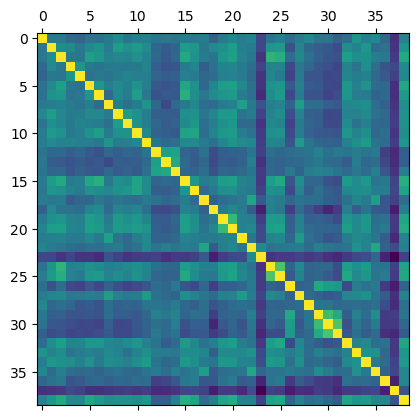

In [7]:
import matplotlib.pyplot as plt
plt.matshow(D.values)

## Computations

In [8]:
D

taxon,Agapetus_sp,Ameletus_inopinatus,Amphinemura_borealis,Baetis_rhodani,Baetis_vernus_group,Capnopsis_schilleri,Diura_sp,Elmis_aenea,Ephemerella_aurivillii,Ephemerella_mucronata,...,Plectrocnemia_sp,Polycentropus_flavomaculatus,Polycentropus_irroratus,Protonemura_sp,Rhyacophila_nubila,Sialis_sp,Silo_pallipes,Simuliidae,Sphaerium_sp,Taeniopteryx_nebulosa
taxon,,,,,,,,,,,,,,,,,,,,,
Agapetus_sp,1.000000,0.749240,0.752280,0.727964,0.718845,0.741641,0.738602,0.756839,0.779635,0.744681,...,0.747720,0.741641,0.711246,0.734043,0.799392,0.762918,0.778116,0.721884,0.642857,0.768997
Ameletus_inopinatus,0.749240,1.000000,0.785714,0.782675,0.750760,0.779635,0.797872,0.758359,0.816109,0.791793,...,0.709726,0.696049,0.680851,0.787234,0.770517,0.803951,0.731003,0.738602,0.645897,0.802432
Amphinemura_borealis,0.752280,0.785714,1.000000,0.749240,0.747720,0.820669,0.803951,0.765957,0.776596,0.773556,...,0.711246,0.694529,0.686930,0.817629,0.790274,0.791793,0.761398,0.750760,0.651976,0.835866
Baetis_rhodani,0.727964,0.782675,0.749240,1.000000,0.799392,0.749240,0.741641,0.753799,0.755319,0.752280,...,0.693009,0.685410,0.670213,0.772036,0.741641,0.790274,0.734043,0.691489,0.674772,0.781155
Baetis_vernus_group,0.718845,0.750760,0.747720,0.799392,1.000000,0.740122,0.750760,0.743161,0.758359,0.772036,...,0.693009,0.673252,0.676292,0.775076,0.758359,0.764438,0.727964,0.699088,0.664134,0.778116
Capnopsis_schilleri,0.741641,0.779635,0.820669,0.749240,0.740122,1.000000,0.800912,0.762918,0.779635,0.762918,...,0.697568,0.677812,0.671733,0.802432,0.764438,0.794833,0.729483,0.721884,0.639818,0.831307
Diura_sp,0.738602,0.797872,0.803951,0.741641,0.750760,0.800912,1.000000,0.731003,0.782675,0.758359,...,0.689970,0.668693,0.682371,0.802432,0.759878,0.755319,0.715805,0.726444,0.639818,0.806991
Elmis_aenea,0.756839,0.758359,0.765957,0.753799,0.743161,0.762918,0.731003,1.000000,0.759878,0.735562,...,0.734043,0.711246,0.699088,0.776596,0.781155,0.790274,0.734043,0.712766,0.647416,0.790274
Ephemerella_aurivillii,0.779635,0.816109,0.776596,0.755319,0.758359,0.779635,0.782675,0.759878,1.000000,0.817629,...,0.708207,0.671733,0.677812,0.768997,0.768997,0.779635,0.738602,0.726444,0.653495,0.794833


In [9]:
def calc_classifier_metrics(df_pred, n_col):
    # Calculate the classification entropy from predictions
    predX = df_pred.values[:,2:n_col].astype(np.float64)
    H = -np.sum(predX*np.log(predX),axis=1)
    df_pred["H"] = H
    # Calculate the ratio between max probable class and the second most probable
    largest = predX.max(axis=1)
    second_largest = np.partition(predX, -2, axis=1)[:, -2]
    r = second_largest/largest
    df_pred["r"] = r
    return df_pred

def re_order_preds(label, D, df_pred, sorting_key):
    candidate_order = D.loc[label].sort_values(ascending=False).drop(label)
    # Re-order the sorted predictions based on DNA proximity
    block_list = []
    for candidate in candidate_order.index:
        block = df_pred.sort_values(sorting_key, ascending=False).query("y_pred == @candidate")[[sorting_key, "is_outlier"]]
        block_list.append(block)

    sorted_df_dna = pd.concat(block_list)
    return sorted_df_dna

def re_order_quantile(label, D, df_pred, sorting_key):
    q = df_pred[sorting_key].quantile(0.8)
    sorted = df_pred.sort_values(sorting_key, ascending=False)
    over_threshold = sorted[sorted[sorting_key]>q]
    under_threshold = sorted[sorted[sorting_key]<=q]

    return pd.concat((re_order_preds(label, D, over_threshold, sorting_key),
               re_order_preds(label, D, under_threshold, sorting_key)), axis=0)


def calculate_all_dfs(label, df_pred, D):
    sorted_dfs = {}
    sorted_dfs["H"] = df_pred.sort_values(by="H", ascending=False)[["H", "is_outlier"]]
    sorted_dfs["r"] = df_pred.sort_values(by="r", ascending=False)[["r", "is_outlier"]]
    sorted_dfs["dna_H"] = re_order_preds(label, D, df_pred, "H")
    sorted_dfs["dna_r"] = re_order_preds(label, D, df_pred, "r")
    sorted_dfs["dna_H_quantile"] = re_order_quantile(label, D, df_pred, "H")
    sorted_dfs["dna_r_quantile"] = re_order_quantile(label, D, df_pred, "r")
    return sorted_dfs

In [10]:
label, model_name = next(iter(zip(config["labels"], config["ckpts"])))
label = "Oxyethira_sp"
model_name =  "outputs/finbenthic2/dnaimg_Oxyethira_sp_efficientnet_b0/f0/dnaimg_Oxyethira_sp_efficientnet_b0_f0_240111-0736-7249_epoch27_val-loss0.22.ckpt"

df_pred, n_col = load_data(label, model_name)
df_pred = calc_classifier_metrics(df_pred, n_col)
sorted_dfs = calculate_all_dfs(label, df_pred, D)

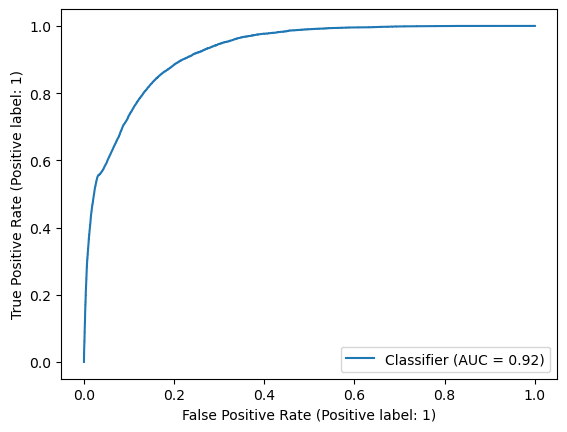

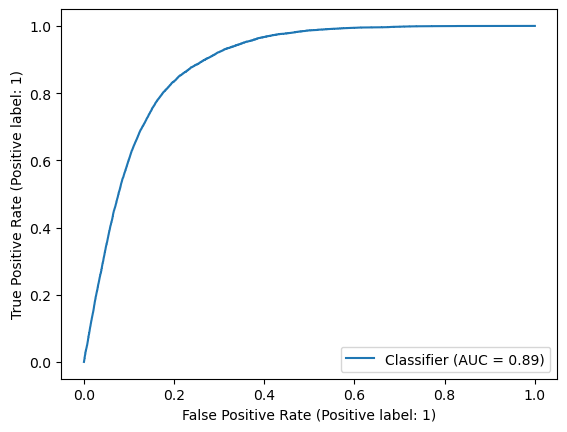

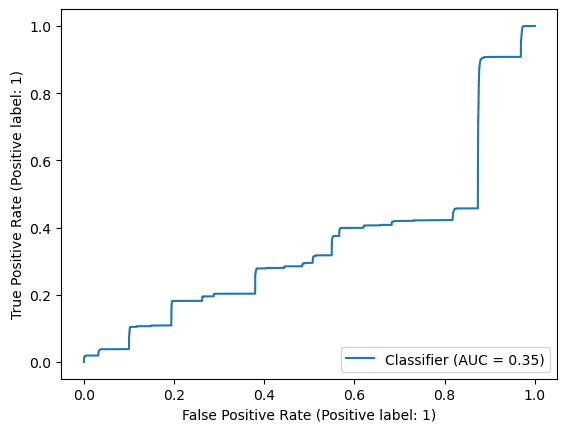

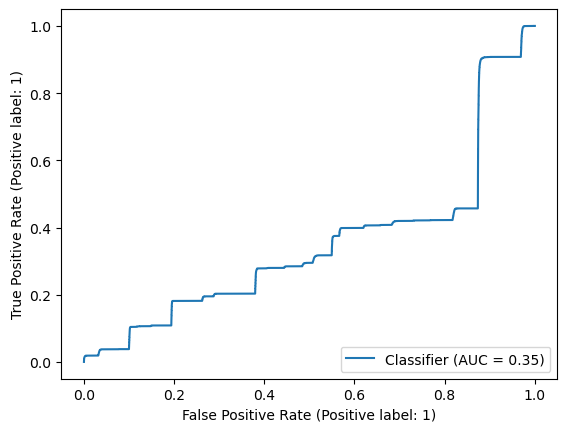

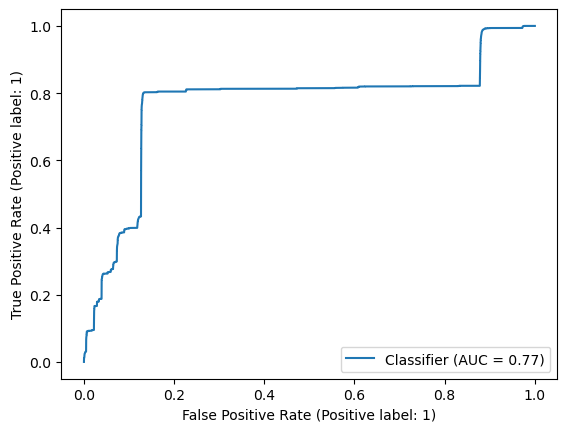

In [11]:
y_pred = np.linspace(1,0, len(sorted_dfs["H"]))
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    sorted_dfs["H"].is_outlier,
    y_pred
)
RocCurveDisplay.from_predictions(
    sorted_dfs["r"].is_outlier,
    y_pred
)
RocCurveDisplay.from_predictions(
    sorted_dfs["dna_H"].is_outlier,
    y_pred
)
RocCurveDisplay.from_predictions(
    sorted_dfs["dna_r"].is_outlier,
    y_pred
)
RocCurveDisplay.from_predictions(
    sorted_dfs["dna_H_quantile"].is_outlier,
    y_pred
)

In [12]:
from sklearn.metrics import roc_auc_score

def calc_aucs(sorted_dfs):
    y_pred = np.linspace(1,0, len(sorted_dfs["H"]))
    aucs = {}
    for key in sorted_dfs.keys():
        auc = roc_auc_score(
            sorted_dfs[key].is_outlier,
            y_pred
        )
        aucs[key] = auc
    return aucs
calc_aucs(sorted_dfs)

{'H': 0.9239693646666591,
 'r': 0.8868292064329445,
 'dna_H': 0.3511960779058353,
 'dna_r': 0.35078959454968417,
 'dna_H_quantile': 0.7683167894873829,
 'dna_r_quantile': 0.7154767117531344}

In [13]:
from tqdm.notebook import tqdm
scores = {}
for label, model_name in tqdm(zip(config["labels"], config["ckpts"]), total=len(config["labels"])):
    df_pred, n_col = load_data(label, model_name)
    df_pred = calc_classifier_metrics(df_pred, n_col)
    sorted_dfs = calculate_all_dfs(label, df_pred, D)

    aucs = calc_aucs(sorted_dfs)
    print(aucs)
    scores[label] = aucs

  0%|          | 0/39 [00:00<?, ?it/s]

{'H': 0.9238306482164304, 'r': 0.887685159015053, 'dna_H': 0.4791487307800315, 'dna_r': 0.4784494595868304, 'dna_H_quantile': 0.8127277312161129, 'dna_r_quantile': 0.7572733932168008}
{'H': 0.8851404806491552, 'r': 0.8604973127275466, 'dna_H': 0.6508302479105205, 'dna_r': 0.6502578884457566, 'dna_H_quantile': 0.8314544522191706, 'dna_r_quantile': 0.8056226351873963}
{'H': 0.9339228610957324, 'r': 0.8930073549311559, 'dna_H': 0.7153641312770146, 'dna_r': 0.7148513699183934, 'dna_H_quantile': 0.8906432988935318, 'dna_r_quantile': 0.8457724053359328}
{'H': 0.7640066345839134, 'r': 0.741547469611018, 'dna_H': 0.841920752014509, 'dna_r': 0.841821979041969, 'dna_H_quantile': 0.8740380846892635, 'dna_r_quantile': 0.8537053722791734}
{'H': 0.6260230859669971, 'r': 0.6021276044262447, 'dna_H': 0.9295771879617438, 'dna_r': 0.9293653189002095, 'dna_H_quantile': 0.8401120169761138, 'dna_r_quantile': 0.8265462749716137}
{'H': 0.9113648582543027, 'r': 0.8753954027326589, 'dna_H': 0.8917347751974014,

In [15]:
score_df = pd.DataFrame(scores).transpose()
score_df["H_delta"] = score_df["H"] - score_df["dna_H_quantile"]
score_df["r_delta"] = score_df["r"] - score_df["dna_r_quantile"]
score_df

,H,r,dna_H,dna_r,dna_H_quantile,dna_r_quantile,H_delta,r_delta
Agapetus_sp,0.923831,0.887685,0.479149,0.478449,0.812728,0.757273,0.111103,0.130412
Ameletus_inopinatus,0.885140,0.860497,0.650830,0.650258,0.831454,0.805623,0.053686,0.054875
Amphinemura_borealis,0.933923,0.893007,0.715364,0.714851,0.890643,0.845772,0.043280,0.047235
Baetis_rhodani,0.764007,0.741547,0.841921,0.841822,0.874038,0.853705,-0.110031,-0.112158
Baetis_vernus_group,0.626023,0.602128,0.929577,0.929365,0.840112,0.826546,-0.214089,-0.224419
Capnopsis_schilleri,0.911365,0.875395,0.891735,0.891203,0.942787,0.914886,-0.031422,-0.039490
Diura_sp,0.759380,0.736277,0.954103,0.953833,0.888216,0.872635,-0.128836,-0.136358
Elmis_aenea,0.755453,0.733096,0.921235,0.920972,0.897756,0.880503,-0.142303,-0.147406
Ephemerella_aurivillii,0.888908,0.847488,0.688358,0.687265,0.850064,0.808671,0.038844,0.038817
Ephemerella_mucronata,0.894212,0.857348,0.855361,0.854650,0.921611,0.895650,-0.027398,-0.038302


In [16]:
score_df.describe()

,H,r,dna_H,dna_r,dna_H_quantile,dna_r_quantile,H_delta,r_delta
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.826808,0.798329,0.817494,0.816520,0.871838,0.844860,-0.045030,-0.046532
std,0.094767,0.089789,0.178688,0.179541,0.051085,0.071147,0.102692,0.114159
min,0.560113,0.532513,0.348234,0.335296,0.753423,0.572634,-0.251815,-0.271274
25%,0.791480,0.773467,0.746528,0.745838,0.838743,0.816816,-0.105342,-0.111728
50%,0.844881,0.810875,0.891735,0.891203,0.890643,0.860066,-0.051829,-0.053280
75%,0.898932,0.864956,0.945632,0.945376,0.910036,0.896798,0.016298,0.014090
max,0.952894,0.911115,0.984492,0.984479,0.942787,0.919277,0.189797,0.221836


c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric

<Axes: xlabel='value', ylabel='index'>

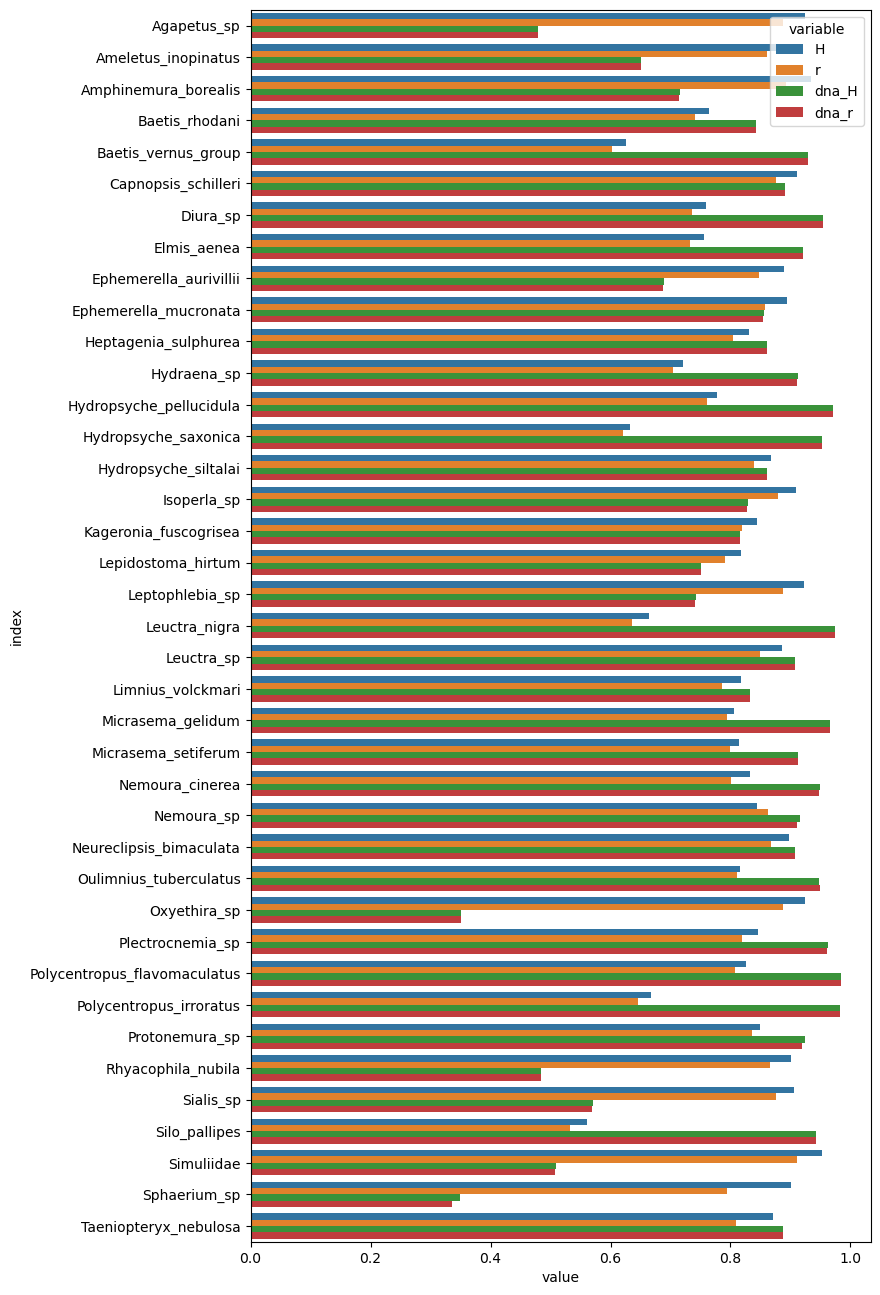

In [17]:
import seaborn as sns
plt.figure(figsize=(8, 16))
sns.barplot(score_df.filter(items=["H", "r", "dna_H", "dna_r"], axis=1).reset_index().melt(id_vars="index"),
            x = "value",
            y = "index",
            hue="variable")

c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categoric

Text(0.5, 1.0, 'Positive = dna ordering is worse')

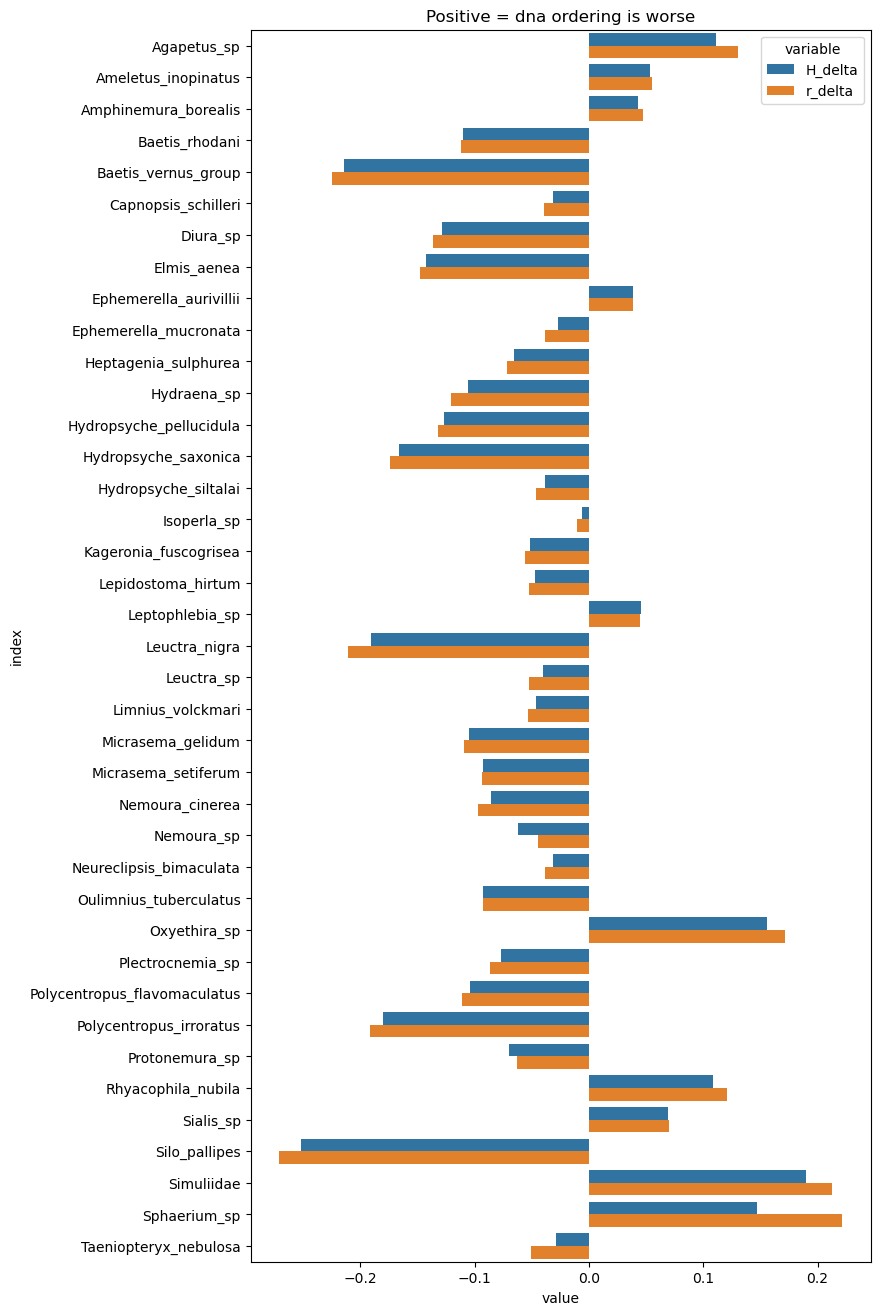

In [18]:
plt.figure(figsize=(8, 16))
sns.barplot(score_df.filter(items=["H_delta", "r_delta"], axis=1).reset_index().melt(id_vars="index"),
            x = "value",
            y = "index",
            hue="variable")
plt.title("Positive = dna ordering is worse")

c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\E1007914\AppData\Local\miniconda3\envs\taxonomist\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='variable', ylabel='value'>

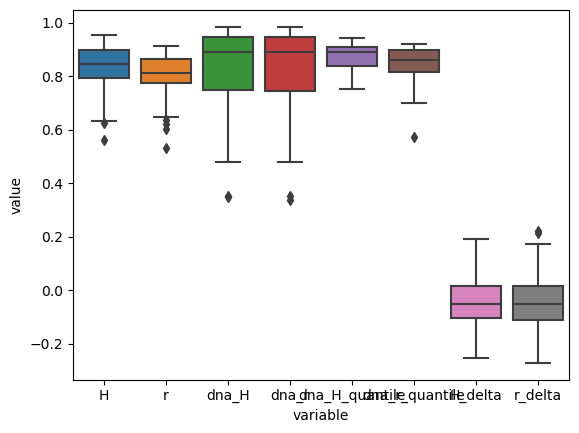

In [19]:
sns.boxplot(score_df.reset_index().melt(id_vars="index"),
            x = "variable",
            y = "value")

In [20]:
from scipy.stats import wilcoxon

wilcoxon(score_df.H, score_df.dna_H_quantile)

WilcoxonResult(statistic=212.0, pvalue=0.012091576707462082)

In [21]:
pd.DataFrame([label_H_mean, label_H_mean])

NameError: name 'label_H_mean' is not defined

In [22]:
H_means = []
pred_means = []
for label, model_name in zip(config["labels"], config["ckpts"]):
    df_pred, n_col = load_data(label, model_name)

    # Pred means
    taxa = df_pred.columns[2:-1]
    assert len(taxa) == 39

    ## Rows with the outlier predictions are removed
    pred_means.append(df_pred.melt(id_vars="y_true",
                value_vars=taxa)
            .query("y_true != @label and variable != @label")
            .groupby(["y_true", "variable"])["value"].mean())


    # Entropy means
    df_pred = calc_classifier_metrics(df_pred, n_col)
    label_H_mean = df_pred.groupby("y_true")["H"].mean()
    label_H_mean.name = label
    H_means.append(label_H_mean)
    print(label)

Agapetus_sp
Ameletus_inopinatus
Amphinemura_borealis
Baetis_rhodani
Baetis_vernus_group
Capnopsis_schilleri
Diura_sp
Elmis_aenea
Ephemerella_aurivillii
Ephemerella_mucronata
Heptagenia_sulphurea
Hydraena_sp
Hydropsyche_pellucidula
Hydropsyche_saxonica
Hydropsyche_siltalai
Isoperla_sp
Kageronia_fuscogrisea
Lepidostoma_hirtum
Leptophlebia_sp
Leuctra_nigra
Leuctra_sp
Limnius_volckmari
Micrasema_gelidum
Micrasema_setiferum
Nemoura_cinerea
Nemoura_sp
Neureclipsis_bimaculata
Oulimnius_tuberculatus
Oxyethira_sp
Plectrocnemia_sp
Polycentropus_flavomaculatus
Polycentropus_irroratus
Protonemura_sp
Rhyacophila_nubila
Sialis_sp
Silo_pallipes
Simuliidae
Sphaerium_sp
Taeniopteryx_nebulosa


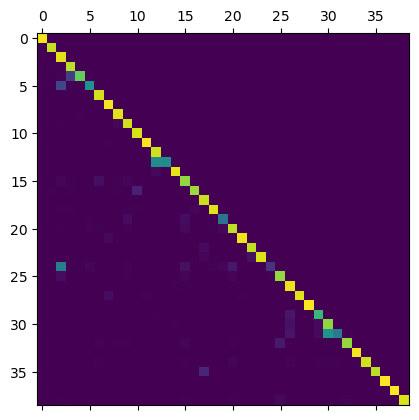

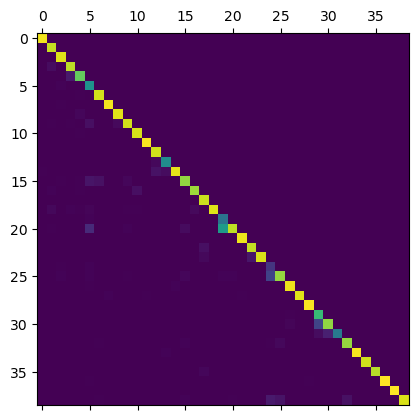

In [24]:
pred_df = pd.concat(pred_means).reset_index().groupby(["y_true", "variable"]).mean()
pred_dist = pred_df.unstack().values
pred_dist_lower = np.tril(pred_dist)
pred_dist_upper = np.triu(pred_dist).T
plt.matshow(pred_dist_lower)
plt.matshow(pred_dist_upper)

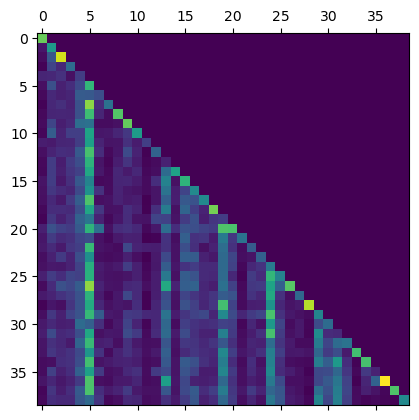

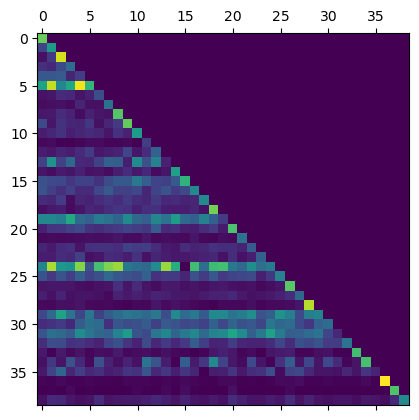

In [25]:
H_dist = pd.DataFrame(H_means).sort_index()
H_dist_lower = np.tril(H_dist)
H_dist_upper = np.triu(H_dist).T
plt.matshow(H_dist_lower)
plt.matshow(H_dist_upper)

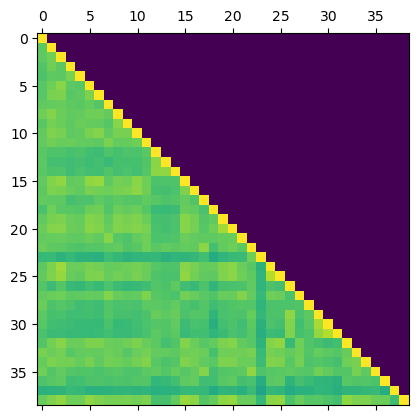

In [26]:
D_lower = np.tril(D)
plt.matshow(D_lower)

C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:2: RuntimeWarning: divide by zero encountered in log
  x = np.log(pred_dist_lower.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:9: RuntimeWarning: divide by zero encountered in log
  x = np.log(pred_dist_upper.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(H_dist_lower.ravel())
C:\Users\E1007914\AppData\Local\Temp\ipykernel_31604\3619067569.py:21: RuntimeWarning: divide by zero encountered in log
  x = np.log(H_dist_upper.ravel())


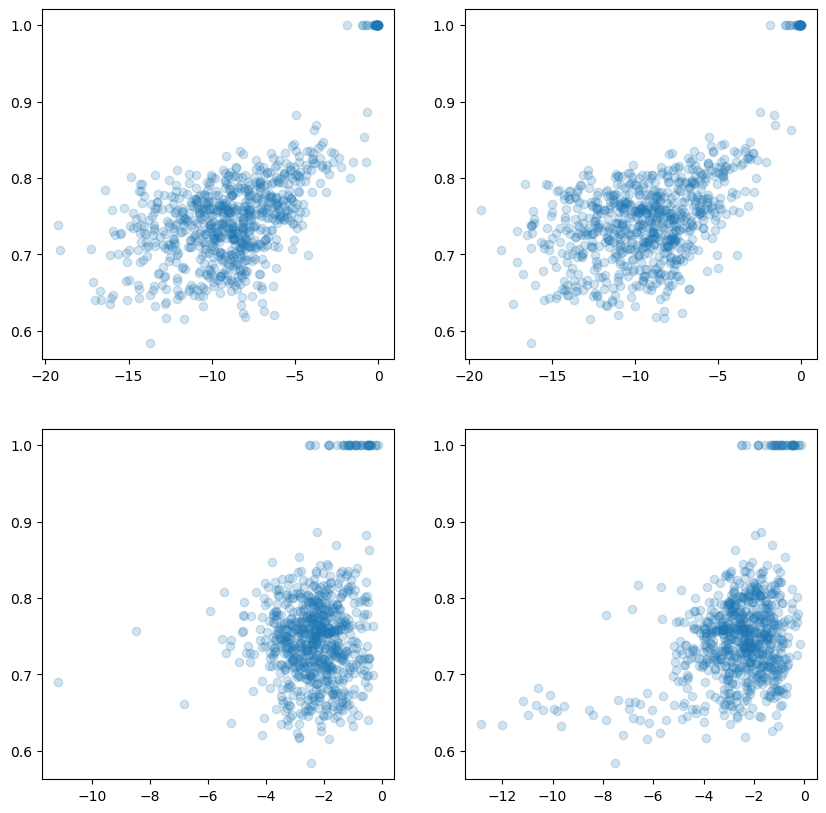

In [42]:
fig,ax =plt.subplots(2,2,figsize=(10,10))
x = np.log(pred_dist_lower.ravel())
y = D_lower.ravel()
ax[0][0].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(pred_dist_upper.ravel())
ax[0][1].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(H_dist_lower.ravel())
ax[1][0].scatter(x,
            y,
            alpha=0.2
            )

x = np.log(H_dist_upper.ravel())
ax[1][1].scatter(x,
            y,
            alpha=0.2
            )

In [43]:
from sklearn.metrics import confusion_matrix

In [81]:
top3_df = []
for label, model_name in zip(config["labels"], config["ckpts"]):
    print(label)
    df_pred, n_col = load_data(label, model_name)

    # Pred means
    taxa = df_pred.columns[2:-1]
    assert len(taxa) == 39

    cm = confusion_matrix(df_pred.y_true, df_pred.y_pred, labels=taxa,normalize="true")
    assert cm.shape == (39,39)

    outlier_preds = cm[0]
    ind = np.argsort(outlier_preds)[::-1][:3]
    top3 = taxa[ind]
    top3_p = outlier_preds[ind]
    top3_dna = D.loc[label][top3].values
    top3_dna_rank = D.loc[label].argsort()[top3].values

    top3_df.append(pd.DataFrame({"outlier":label,
                "rank": np.arange(1,4),
                "taxa": top3,
                "pred_p": top3_p,
                "DNA_dist": top3_dna,
                "DNA_rank": top3_dna_rank})
    )

Agapetus_sp
Ameletus_inopinatus
Amphinemura_borealis
Baetis_rhodani
Baetis_vernus_group
Capnopsis_schilleri
Diura_sp
Elmis_aenea
Ephemerella_aurivillii
Ephemerella_mucronata
Heptagenia_sulphurea
Hydraena_sp
Hydropsyche_pellucidula
Hydropsyche_saxonica
Hydropsyche_siltalai
Isoperla_sp
Kageronia_fuscogrisea
Lepidostoma_hirtum
Leptophlebia_sp
Leuctra_nigra
Leuctra_sp
Limnius_volckmari
Micrasema_gelidum
Micrasema_setiferum
Nemoura_cinerea
Nemoura_sp
Neureclipsis_bimaculata
Oulimnius_tuberculatus
Oxyethira_sp
Plectrocnemia_sp
Polycentropus_flavomaculatus
Polycentropus_irroratus
Protonemura_sp
Rhyacophila_nubila
Sialis_sp
Silo_pallipes
Simuliidae
Sphaerium_sp
Taeniopteryx_nebulosa


In [91]:
top3 = pd.concat(top3_df).reset_index(drop=True)
top3 = top3.pivot(index="outlier",columns="rank",values=["taxa", "pred_p", "DNA_dist", "DNA_rank"]).stack()
top3 = top3.astype({"pred_p": np.float64,
             "DNA_dist": np.float64,
             "DNA_rank": float})
top3

taxa    pred_p  DNA_dist  \
outlier               rank                                                
Agapetus_sp           1        Hydropsyche_siltalai  0.305971  0.744681   
                      2     Neureclipsis_bimaculata  0.197887  0.734043   
                      3          Lepidostoma_hirtum  0.152082  0.759878   
Ameletus_inopinatus   1              Baetis_rhodani  0.577687  0.782675   
                      2             Leptophlebia_sp  0.242357  0.779635   
...                                             ...       ...       ...   
Sphaerium_sp          2                  Simuliidae  0.249856  0.620061   
                      3     Hydropsyche_pellucidula  0.167917  0.633739   
Taeniopteryx_nebulosa 1              Protonemura_sp  0.435283  0.828267   
                      2                  Nemoura_sp  0.395100  0.832827   
                      3                 Isoperla_sp  0.065605  0.844985   

                            DNA_rank  
outlier               rank            
Agapetus_sp           1         14.0  
                      2         10.0  
                      3         13.0  
Ameletus_inopinatus   1         26.0  
                      2         33.0  
...                              ...  
Sphaerium_sp          2         22.0  
                      3          0.0  
Taeniopteryx_nebulosa 1         19.0  
                      2         11.0  
                      3          0.0  

[117 rows x 4 columns]

In [92]:
import plotly.express as px
px.scatter(top3.reset_index(),
           x="pred_p",
           y="DNA_dist",
           color="DNA_rank",
           hover_data=["outlier", "taxa"],
           width=800,
           height=800)

In [85]:
np.corrcoef(top3.pred_p.values,
            top3.DNA_dist.values)

array([[1.        , 0.29414248],
       [0.29414248, 1.        ]])

In [97]:
np.corrcoef(top3.reset_index()["rank"],
            top3.reset_index().DNA_rank)

array([[ 1.        , -0.15090298],
       [-0.15090298,  1.        ]])

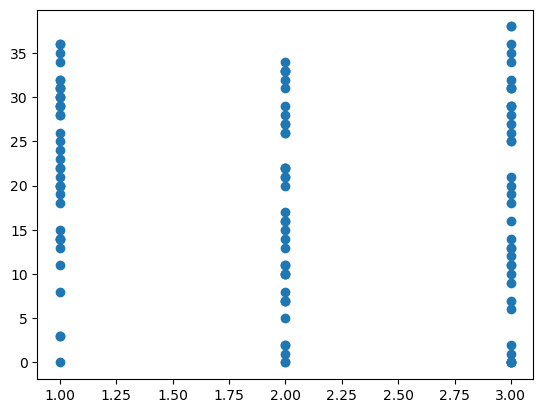

In [98]:
plt.scatter(top3.reset_index()["rank"],
            top3.reset_index().DNA_rank)